In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.where(x > 0, x, 0)

def softmax(x):
    m = np.max(x,1).reshape(-1,1)
    c = x - m
    return np.exp(c)/np.sum(np.exp(c),1).reshape(-1,1)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [3]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

def binary_crossentropy(y, y_hat):
    epsilon = 1e-7
    return -np.mean((1-y)*np.log(1-y_hat+epsilon)+y*np.log(y_hat+epsilon))

def categorical_crossentropy(y, y_hat):
    epsilon = 1e-7
    return -np.mean(y*np.log(y_hat+epsilon))

In [4]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        return sigmoid(x)
    
    def backward(self,out):
        dout = sigmoid(out) * sigmoid(1-sigmoid(out))
        return dout

In [5]:
class ReLU:
    def __init__(self):
        self.out = None
        
    def forward(self,x):
        out = relu(x)
        self.out = np.where(out>0, 1, 0)
        return out
    
    def backward(self,out):
        dout = self.out * out
        return dout

In [6]:
class Affine:
    def __init__(self,w,b):
        self.x = None
        self.w = w
        self.b = b
        self.lambda_reg = 1e-3
    
    def forward(self,x):
        self.x = x
        self.dout = np.dot(self.x,self.w) + self.b
        return self.dout
    
    def backward(self,out):
        self.dout = np.dot(out, self.w.T)
        self.dW = np.dot(self.x.T,out) + self.lambda_reg * self.w
        self.db = np.sum(out,axis=0)
        return self.dout

In [7]:
class Tanh:
    def __init__(self):
        self.out = None
        
    def forward(self,x):
        return tanh(x)
    
    def backward(self):
        dout = 1 - tanh(out)**2
        return dout

In [8]:
class SoftmaxWithLoss:
    def __init__(self):
        self.out = None
        self.y = None
        self.y_hat = None
    
    def forward(self,x):
        self.y_hat = softmax(x)
        return self.y_hat
    
    def backward(self,y):
        self.y = y
        self.dout = (self.y_hat - self.y) / len(self.y)
        return self.dout

In [9]:
def sigdiff(x):
    return sigmoid(x) * (1-sigmoid(x))

def tanhdiff(x):
    return 1-tanh(x)**2

In [10]:
s = Sigmoid()

In [11]:
x = np.random.randn(3,2)
w = np.random.randn(2,2)

In [12]:
out = np.dot(s.forward(x),w)
s.forward(x), s.backward(out)

(array([[0.50178917, 0.05713558],
        [0.3385475 , 0.83997881],
        [0.4825312 , 0.31278775]]),
 array([[0.33414491, 0.33743307],
        [0.34253758, 0.42778136],
        [0.33832835, 0.37358989]]))

In [13]:
r = ReLU()

In [14]:
x = np.array([[-5,6],[2,0],[-1,3]])
dx = np.array([[100,-5],[-7,-3],[7,10]])

In [15]:
r.forward(x), r.backward(dx)

(array([[0, 6],
        [2, 0],
        [0, 3]]),
 array([[ 0, -5],
        [-7,  0],
        [ 0, 10]]))

In [16]:
x = np.random.randn(4,2)
w = np.random.randn(2,5)
b = np.zeros(5)

In [17]:
a = Affine(w,b)

In [18]:
a.forward(x)

array([[ 2.16541783, -0.75853682, -2.78083209,  0.65816231, -1.72946529],
       [ 2.02545789, -1.1941024 , -1.97796043, -0.03791948, -1.32773268],
       [-0.95319099, -0.76876648,  2.64199912, -1.77681498,  1.4210558 ],
       [ 0.47499809, -1.73463687,  1.40660557, -1.97063044,  0.55897172]])

In [19]:
a.backward(a.forward(x))

array([[ 10.38827595,  -1.02842696],
       [  7.24878262,  -2.16223493],
       [-10.18872355,  -2.27847029],
       [ -5.70842571,  -4.10995433]])

In [20]:
sm = SoftmaxWithLoss()

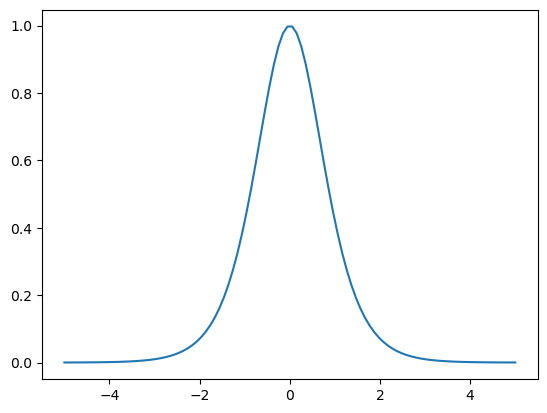

In [21]:
x = np.linspace(-5,5,100)
y = tanhdiff(x)
plt.plot(x,y)

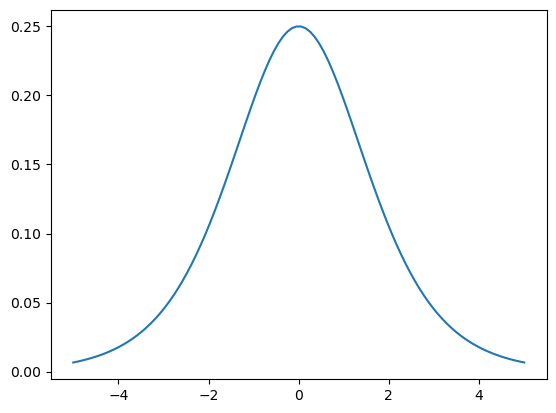

In [22]:
x = np.linspace(-5,5,100)
y = sigdiff(x)
plt.plot(x,y)

In [23]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras import activations
# from tensorflow.keras.layers import ReLU
# from tensorflow.keras.optimizers import Adam
# model = Sequential()
# model.add(Dense(100,activation='relu',input_shape=(784,)))
# model.add(Dense(10,activation='sigmoid'))
# opt = Adam(lr=1e-4)

In [24]:
class Net:
    def __init__(self,input_shape):
        self.x = None
        self.y = None
        self.input_shape = input_shape
        self.layers = []
        self.activation_dic = {
            'relu':ReLU,
            'sigmoid':Sigmoid,
            'softmax':SoftmaxWithLoss,
            'tanh':Tanh
        }
        self.grad = None
        
    def add(self,output_shape,activation):
        if len(self.layers) == 0:
            w = np.random.randn(self.input_shape,output_shape) / np.sqrt(self.input_shape)
            b = np.zeros(output_shape)
            activation = self.activation_dic.get(activation)
            self.layers.append([w,b,activation])
        else:
            input_shape = self.layers[-1][0].shape[1]
            w = np.random.randn(input_shape, output_shape) / np.sqrt(input_shape)
            b = np.zeros(output_shape)
            activation = self.activation_dic.get(activation)
            self.layers.append([w,b,activation])
    
    def _build(self):
        self.W = {}
        for i, layer in enumerate(self.layers,1):
            w = layer[0]
            b = layer[1]
            activation = layer[2]
            self.W['Affine_'+str(i)] = Affine(w,b)
            self.W['Activation_'+str(i)] = activation()
        return f'Building Success'
    
    def compile(self,lr,loss,metrics):
        loss_func_dic = {
            'rmse' : rmse,
            'binary_crossentropy' : binary_crossentropy,
            'categorical_crossentropy' : categorical_crossentropy
        }
        metrics_dic = {
            'accuracy' : 'accuracy',
            'rmse' : 'rmse',
        }
        
        self.loss_func = loss_func_dic[loss]
        self.metrics = metrics_dic[metrics]
        self.lr = lr
        
        
    def predict(self,x):
        if self.grad == None:
            self._build()
        self.y_hat = x
        for k, v in self.W.items():
            self.y_hat = v.forward(self.y_hat)
        return self.y_hat
    
    def gradient(self,x,y):
        self.y_hat = self.predict(x)
        self.y = y
        self.grad = {}
        last_layer = list(self.W.keys())[-1]
        out = self.W.get(last_layer).backward(self.y)
        for key in list(self.W.keys())[::-1]:
            out = self.W.get(key).backward(out)
        idx = 1
        for key in list(self.W.keys()):
            if 'Affine' in key:
                self.grad['W'+str(idx)] = self.W.get(key).dW
                self.grad['b'+str(idx)] = self.W.get(key).db
                idx += 1
        return self.grad
        
    def loss(self,x,y):
        y_hat = self.predict(x)
        loss_val = categorical_crossentropy(y,y_hat)
        accuracy = np.sum(np.argmax(y_hat, 1) == np.argmax(y, 1))/len(y)
        return [accuracy, loss_val]
    
    def summary(self):
        total_params = 0
        if self.grad == None:
            self._build()
        print("----------------------------------------------")
        print("                Output Shape           Param #")
        print("==============================================")
        for idx, layer in enumerate(self.layers,1):
            tmp_length = 20 - len(str(layer[0].shape[1]))
            print(f'Affine_{idx}        (None, {layer[0].shape[1]}) {np.prod(layer[0].shape) + layer[0].shape[1]:>{tmp_length}}')
            total_params += np.prod(layer[0].shape) + layer[0].shape[1]
        print("==============================================")
        print(f"total params: {total_params}")
    
    def fit(self, x, y, epochs=10):
        for epoch in tqdm(range(epochs)):
            self.grad = self.gradient(x,y)
            print(f'{epoch+1} ===========> accuracy : {self.loss(x,y)[0]}, loss : {self.loss(x,y)[1]}')
            for idx, _ in enumerate(self.layers,1):
                self.W.get('Affine_'+str(idx)).w -= self.lr * self.grad['W'+str(idx)]
                self.W.get('Affine_'+str(idx)).b -= self.lr * self.grad['b'+str(idx)]

In [25]:
model = Net(10)

In [26]:
model.add(100,activation='relu')

In [27]:
model.summary()

----------------------------------------------
                Output Shape           Param #
Affine_1        (None, 100)              1100
total params: 1100


In [28]:
model.layers

[[array([[ 6.68173058e-01, -1.96502609e-01, -4.11723925e-01,
           1.17433176e-01, -6.85546291e-02, -3.45824955e-01,
           2.91945872e-02,  5.56696219e-01,  2.81281909e-01,
          -1.30012267e-01, -2.33013944e-02,  1.70403767e-01,
           1.99287908e-01,  2.82584396e-01,  2.10337665e-01,
           2.20788398e-01,  3.12559730e-01, -2.39836064e-01,
           4.17025735e-01, -4.90977657e-01, -3.93158212e-02,
          -2.04653271e-01, -4.57395989e-01,  2.84877491e-01,
          -1.60673436e-02,  5.28233848e-01, -1.91635035e-01,
           1.88688334e-01,  4.72315889e-02,  8.28590061e-02,
          -2.51204397e-01, -6.38581771e-01,  1.48714818e-01,
           1.01473085e-01, -1.55645276e-01, -2.08739586e-01,
          -2.12236924e-01,  7.44846128e-01,  1.18219218e-01,
           5.08145650e-01, -4.37130174e-01, -2.89047168e-01,
          -1.66805593e-01, -1.57778758e-01,  1.39152697e-01,
           2.12710556e-01, -1.47584481e-01, -3.42645836e-02,
           2.51115284e-0

In [29]:
model.add(100,activation='sigmoid')

In [30]:
model._build()

'Building Success'

In [31]:
pred = model.predict(np.random.randn(7,10))

In [32]:
model.y_hat

array([[0.73049957, 0.16341549, 0.50654328, 0.40525037, 0.34481578,
        0.84578022, 0.41855464, 0.13249411, 0.57199338, 0.61770154,
        0.40424116, 0.46669295, 0.76221877, 0.18708185, 0.6097706 ,
        0.52368872, 0.76696755, 0.82149788, 0.34978473, 0.34515573,
        0.40828458, 0.32450809, 0.22278262, 0.54270063, 0.47870081,
        0.59522262, 0.4970827 , 0.25410594, 0.31836832, 0.63396725,
        0.48740491, 0.54839821, 0.39721383, 0.44010129, 0.85091344,
        0.36224966, 0.67748696, 0.35609943, 0.35797526, 0.50954061,
        0.47477109, 0.49288131, 0.69499997, 0.60449717, 0.18881549,
        0.77530227, 0.54272287, 0.15799033, 0.71688572, 0.25351606,
        0.37390201, 0.70652019, 0.52240657, 0.6980654 , 0.61820959,
        0.18571401, 0.63945103, 0.65271188, 0.60585424, 0.25746357,
        0.45834523, 0.6799044 , 0.66711033, 0.22615048, 0.49752661,
        0.30180908, 0.60253233, 0.51479213, 0.35923112, 0.81790727,
        0.393468  , 0.35837807, 0.39584893, 0.78

In [33]:
# 원핫 만들기
from tensorflow.keras.utils import to_categorical

In [34]:
model = Net(10)

In [35]:
model.add(256,activation='relu')
model.add(128,activation='relu')
model.add(10,activation='softmax')

In [36]:
model.compile(lr = 1e-3, loss = 'categorical_crossentropy', metrics = 'accuracy' )

In [37]:
model.summary()

----------------------------------------------
                Output Shape           Param #
Affine_1        (None, 256)              2816
Affine_2        (None, 128)             32896
Affine_3        (None, 10)               1290
total params: 37002


In [38]:
x = np.random.randn(1000,10)
y = to_categorical(np.random.randint(0,10,1000))
model.gradient(x,y)

{'W1': array([[-1.34193682e-03,  7.59391097e-04,  3.47702312e-03, ...,
         -6.83087407e-03, -7.45020701e-04,  1.08605701e-03],
        [ 9.18640906e-04,  2.47119424e-03,  4.36488382e-03, ...,
         -4.39214559e-03,  1.34641295e-03, -1.81140785e-03],
        [ 3.11159711e-03, -4.07543822e-04, -1.12067664e-03, ...,
          4.44895269e-03,  3.31659912e-03, -1.82863302e-03],
        ...,
        [ 7.18960176e-05,  2.01629923e-03,  3.61433508e-03, ...,
          1.46968868e-03, -4.82622443e-04, -3.00673977e-03],
        [-1.14838157e-04,  8.42889798e-04, -1.73846760e-03, ...,
         -3.76582888e-03, -4.55242276e-05,  5.55977133e-03],
        [-1.55810624e-03, -7.74986680e-04, -6.74553225e-04, ...,
          2.83970779e-03,  3.35312822e-03, -3.45224167e-03]]),
 'b1': array([ 3.23517239e-03, -3.46989716e-03, -9.07431109e-03, -3.22436084e-03,
        -5.33223269e-03,  3.58216703e-03,  1.51999581e-03, -8.70989330e-03,
         7.46858680e-03,  1.43171641e-02,  9.63329603e-03, -3.728

In [39]:
model.W['Affine_2'].db.size

128

In [40]:
from tqdm import tqdm
from time import time, sleep

In [41]:
for i in tqdm(range(20)):
    sleep(1)
    print(i)

  5%|████▏                                                                              | 1/20 [00:01<00:19,  1.00s/it]

0


 10%|████████▎                                                                          | 2/20 [00:02<00:18,  1.00s/it]

1


 15%|████████████▍                                                                      | 3/20 [00:03<00:17,  1.00s/it]

2


 20%|████████████████▌                                                                  | 4/20 [00:04<00:16,  1.00s/it]

3


 25%|████████████████████▊                                                              | 5/20 [00:05<00:15,  1.00s/it]

4


 30%|████████████████████████▉                                                          | 6/20 [00:06<00:14,  1.00s/it]

5


 35%|█████████████████████████████                                                      | 7/20 [00:07<00:13,  1.00s/it]

6


 40%|█████████████████████████████████▏                                                 | 8/20 [00:08<00:12,  1.00s/it]

7


 45%|█████████████████████████████████████▎                                             | 9/20 [00:09<00:11,  1.00s/it]

8


 50%|█████████████████████████████████████████                                         | 10/20 [00:10<00:10,  1.00s/it]

9


 55%|█████████████████████████████████████████████                                     | 11/20 [00:11<00:09,  1.00s/it]

10


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:12<00:08,  1.00s/it]

11


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:13<00:07,  1.00s/it]

12


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:14<00:06,  1.00s/it]

13


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:15<00:05,  1.00s/it]

14


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:16<00:04,  1.00s/it]

15


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:17<00:03,  1.00s/it]

16


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:18<00:02,  1.00s/it]

17


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:19<00:01,  1.00s/it]

18


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/it]

19


In [42]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [43]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [44]:
X_train = X_train.reshape(-1,784) / 255.0
X_test = X_test.reshape(-1,784) / 255.0

In [45]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [52]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [57]:
model = Net(784)

In [58]:
model.add(1024,activation='relu')
model.add(512,activation='relu')
model.add(256,activation='relu')
model.add(64,activation='relu')
model.add(10,activation='softmax')

In [59]:
model.compile(lr = 1e-5, loss='categorical_crossentropy', metrics='accuracy')

In [60]:
model.fit(X_train, y_train,epochs=10)

 10%|████████▎                                                                          | 1/10 [00:10<01:33, 10.35s/it]

1 ===========> accuracy : 0.11598333333333333, loss : 0.2328070830822221


 20%|████████████████▌                                                                  | 2/10 [00:20<01:22, 10.36s/it]

2 ===========> accuracy : 0.116, loss : 0.23280683045756664


 30%|████████████████████████▉                                                          | 3/10 [00:31<01:13, 10.47s/it]

3 ===========> accuracy : 0.11603333333333334, loss : 0.23280657808377586


 40%|█████████████████████████████████▏                                                 | 4/10 [00:41<01:03, 10.55s/it]

4 ===========> accuracy : 0.11608333333333333, loss : 0.23280632593047418


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:53<00:53, 10.72s/it]

5 ===========> accuracy : 0.11605, loss : 0.23280607389584168


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:04<00:44, 11.08s/it]

6 ===========> accuracy : 0.11606666666666667, loss : 0.23280582199744598


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:16<00:33, 11.23s/it]

7 ===========> accuracy : 0.11605, loss : 0.23280557018469702


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:27<00:22, 11.16s/it]

8 ===========> accuracy : 0.11603333333333334, loss : 0.2328053185493858


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:37<00:10, 10.87s/it]

9 ===========> accuracy : 0.11603333333333334, loss : 0.2328050670666011


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.87s/it]

10 ===========> accuracy : 0.116, loss : 0.2328048156100597


In [50]:
model.W

{'Affine_1': <__main__.Affine at 0x1c10ccbf750>,
 'Activation_1': <__main__.ReLU at 0x1c108f7cdd0>,
 'Affine_2': <__main__.Affine at 0x1c10dcbee50>,
 'Activation_2': <__main__.SoftmaxWithLoss at 0x1c10dcc1890>}

In [61]:
model.summary()

----------------------------------------------
                Output Shape           Param #
Affine_1        (None, 1024)           803840
Affine_2        (None, 512)            524800
Affine_3        (None, 256)            131328
Affine_4        (None, 64)              16448
Affine_5        (None, 10)                650
total params: 1477066


In [62]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the images (reshape if needed)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Create and compile your model (similar to the previous Net class)
model = Net(input_shape=32 * 32 * 3)
model.add(output_shape=128, activation='relu')
model.add(output_shape=10, activation='softmax')
model.compile(lr=1e-3, loss='categorical_crossentropy', metrics='accuracy')

# Train the model
model.fit(X_train, y_train, epochs=10)

170498071/170498071 [==============================] - 78s 0us/step


 10%|████████▎                                                                          | 1/10 [00:02<00:23,  2.65s/it]

1 ===========> accuracy : 0.09714, loss : 0.23708599329912391


 20%|████████████████▌                                                                  | 2/10 [00:05<00:21,  2.66s/it]

2 ===========> accuracy : 0.09748, loss : 0.23661106761802025


 30%|████████████████████████▉                                                          | 3/10 [00:07<00:18,  2.64s/it]

3 ===========> accuracy : 0.09736, loss : 0.23618234809590136


 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:15,  2.65s/it]

4 ===========> accuracy : 0.09818, loss : 0.23579689333428794


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:13<00:13,  2.66s/it]

5 ===========> accuracy : 0.0988, loss : 0.23545288109589407


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:15<00:10,  2.66s/it]

6 ===========> accuracy : 0.09978, loss : 0.23514888885804855


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:18<00:08,  2.67s/it]

7 ===========> accuracy : 0.09988, loss : 0.23488232764037623


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:21<00:05,  2.68s/it]

8 ===========> accuracy : 0.10014, loss : 0.23465100095164187


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:23<00:02,  2.67s/it]

9 ===========> accuracy : 0.10014, loss : 0.23445246629170466


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]

10 ===========> accuracy : 0.10144, loss : 0.23428466967104616
